# Compare our three methods

## Import and input

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA

train1 = pd.read_csv('../data/training_1.csv')
train2 = pd.read_csv('../data/training_2.csv')

## Define comparison metric

In [2]:
def compute_S(anomalies, gamma):    
    # attack intervals
    attacks = [
        [1731, 1772],
        [2337, 2396],
        [2851, 2887],
        [3508, 3514],
        [3741, 3813]
    ]
    # construct truth signal
    truth = np.zeros(len(anomalies))
    for attack in attacks:
        truth[attack[0]:attack[1]] = 1
    
    # compute s_ttd
    s = 0
    for attack in attacks:
        t = attack[1] - attack[0] + 1
        ttd = t
        flags = anomalies[attack[0]:attack[1]]
        for i, flag in enumerate(flags):
            if flag == 1:
                ttd = i
                break
        s += ttd / t
    s_ttd = 1 - s/len(attacks)
    
    # compute s_cm
    TP = len([x for i,x in enumerate(anomalies) if x == 1 and truth[i] == 1])
    TN = len([x for i,x in enumerate(anomalies) if x == 0 and truth[i] == 0])
    TPR = TP / sum(truth)
    TNR = TN / (len(truth) - sum(truth))
    s_cm = 0.5 * (TPR + TNR)
    print("TPR/TNR : {}/{}".format(TPR,TNR))
    
    # return S
    S = gamma * s_ttd + (1-gamma) * s_cm
    return (S, s_ttd, s_cm)

## Visually compare

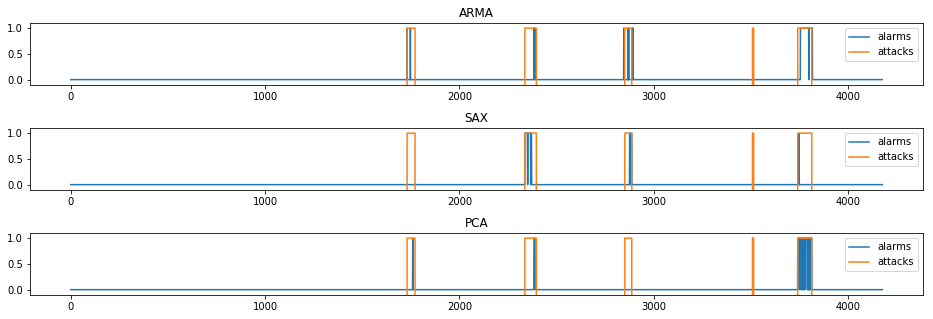

In [3]:
methods = ['arma', 'sax', 'pca']

# set size
fig = plt.figure(figsize=(16,5))
plt.subplots_adjust(hspace=0.7)
for i, method in enumerate(methods):
    # load predictions
    pred = np.load('../data/{}_pred.npy'.format(method))

    # plot the prediction
    ax = fig.add_subplot(3,1,i+1)
    ax.set_title(method.upper())
    ax.set_ylim([-0.1,1.1])
    ax.plot(pred,label='alarms')
    ax.plot(train2['ATT_FLAG'],label='attacks')
    ax.legend()

# show
plt.savefig('comparison')
plt.show()

## Compare based on S-score

In [4]:
methods = ['arma', 'sax', 'pca']
gamma = 0.1

for method in methods:
    # load predictions
    pred = np.load('../data/{}_pred.npy'.format(method))
    S = compute_S(pred,gamma)
    print("{}: {}".format(method,S[0]))
    
S_baseline0 = compute_S(np.zeros(len(train2['ATT_FLAG'])),gamma)
print("baseline_0: {}".format(S_baseline0[0]))
S_baseline1 = compute_S(np.ones(len(train2['ATT_FLAG'])),gamma)
print("baseline_1: {}".format(S_baseline1[0]))

TPR/TNR : 0.3037383177570093/0.997476659096644
arma: 0.636855267289932
TPR/TNR : 0.18691588785046728/0.9997476659096644
sax: 0.5785672774593675
TPR/TNR : 0.27102803738317754/0.9997476659096644
pca: 0.6138014474341599
TPR/TNR : 0.0/1.0
baseline_0: 0.45
TPR/TNR : 1.0/0.0
baseline_1: 0.55
